# Data Mining - Assignment 1

In [1]:
import pandas as pd
import numpy as np
import copy
from itertools import combinations
import math
import time
import matplotlib.pyplot as plt

df = pd.read_csv("dataset.csv")

# making an empty row with 32 empty fields
empty_row = ""
for i in range(31):
    empty_row += ","

# adding the empty row above all records
if df.columns[0] != "Unnamed: 0":
    with open("dataset.csv", 'r+') as f:
        content = f.read()
        f.seek(0, 0)
        f.write(empty_row + '\n' + content)

df = pd.read_csv("dataset.csv")

# naming fields of the empty row
col_names = {}
for i in range(32):
    curr_index = "Unnamed: " + str(i)
    next_index = "food " + str(i)
    col_names[curr_index] = next_index
df.rename(columns = col_names, inplace=True)

df.head()

,food 0,food 1,food 2,food 3,food 4,food 5,food 6,food 7,food 8,food 9,...,food 22,food 23,food 24,food 25,food 26,food 27,food 28,food 29,food 30,food 31
0,citrus fruit,semi-finished bread,margarine,ready soups,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,tropical fruit,yogurt,coffee,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,whole milk,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,pip fruit,yogurt,cream cheese,meat spreads,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,other vegetables,whole milk,condensed milk,long life bakery product,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [2]:
# Creating a 2D list containing all transactions. The shape is to be: [transactions][items]
transactions = []
for i in range(len(df)):
    transaction = []
    for each in df.loc[i]:
        if each is not np.nan:
            transaction.append(each)
    transactions.append(transaction)

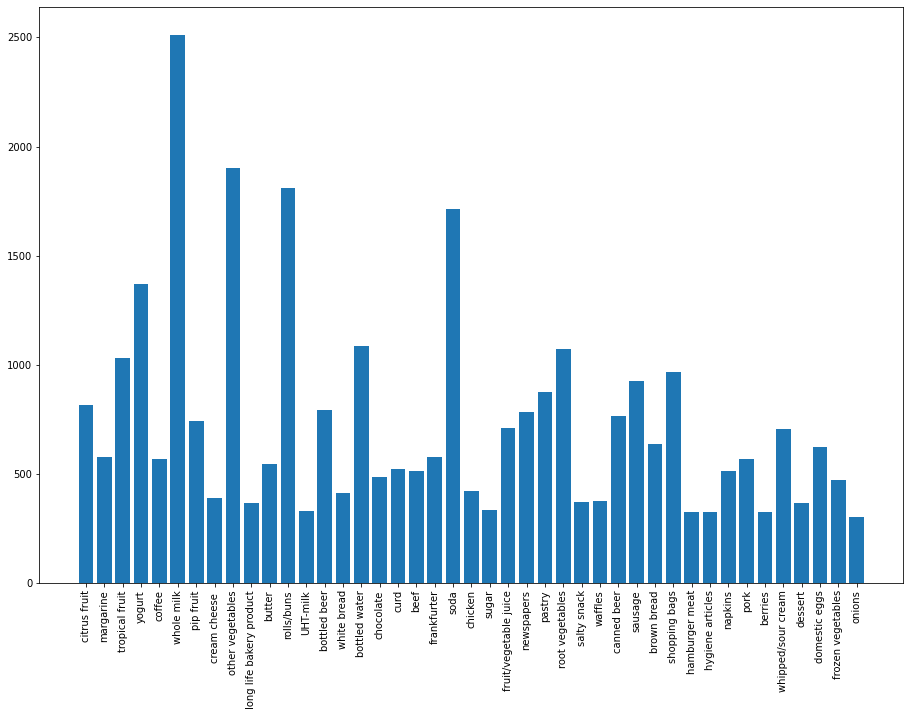

In [3]:
# Exploratory Analysis
# A bar plot to display best-seller items with their frequencies
fig = plt.figure(1, [12, 8])
ax = fig.add_axes([0,0,1,1])
x_transactions = []
y_freqs = []
uniq_items = {}
for transaction in transactions:
            for item in transaction:
                if item in uniq_items:
                    uniq_items[item] += 1
                else:
                    uniq_items[item] = 1
for key, value in uniq_items.items():
    if value >= 300:
        x_transactions.append(key)
        y_freqs.append(value)
ax.bar(x_transactions, y_freqs)
plt.setp(ax.get_xticklabels(), rotation='vertical')
plt.show()

In [26]:
class Arules:
    def __init__(self, transactions):
        self.items = {} # For storing distinct items. key is item, value is frequency
        self.transactions = transactions
        self.items_presence_indexes = {} # To see each item is present in which transactions
        self.add_unique_items()
        self.fill_items_presence_indexes()
    
    
    """ For storing distinct items with their frequencies in self.items dict """
    def add_unique_items(self):
        for transaction in self.transactions:
            for item in transaction:
                if item in self.items:
                    self.items[item] += 1
                else:
                    self.items[item] = 1

    
    # To keep track of items' presence in the transactions
    def fill_items_presence_indexes(self):
        for i in range (len(transactions)):
            for item in transactions[i]:
                if item not in self.items_presence_indexes:
                    self.items_presence_indexes[item] = set()
                self.items_presence_indexes[item].add(i)

    
    """ A function to mine frequent itemsets among all transactions with the given min_support """
    def get_frequent_item_sets(self, min_support):
        freq_item_sets = []
        first_freq_items = dict(filter(lambda x: x[1] >= min_support*len(self.transactions), self.items.items()))
        first_freq_items = list(first_freq_items.keys())
        first_freq_items = [[first_freq_items[i]] for i in range(len(first_freq_items))]
        
        k_minus_1_freq_items = copy.deepcopy(first_freq_items)
        while True:
            # Generating Ck from Lk-1
            kth_candidates = self.gen_next_candidates(k_minus_1_freq_items)
            kth_candidates_freqs = [0 for i in range(len(kth_candidates))]
            
            # Counting each candicate itemset frequency
            for i in range(len(kth_candidates)):
                intersected_indexes = None
                for item in kth_candidates[i]:
                    indexes = self.items_presence_indexes[item]
                    if intersected_indexes is None:
                        intersected_indexes = indexes
                    intersected_indexes = intersected_indexes.intersection(indexes)
                kth_candidates_freqs[i] += len(intersected_indexes)
            
            # Deleting candidates than don't satisfy the min_support condition
            for i in range (len(kth_candidates_freqs) - 1, -1, -1):
                if kth_candidates_freqs[i] < math.ceil(len(self.transactions)*min_support):
                    del kth_candidates[i]
            
            # Adding the final itemsets (candidates) to the frequent itemsets list
            k_minus_1_freq_items = copy.deepcopy(kth_candidates)
            freq_item_sets.extend(k_minus_1_freq_items)
            
            # if there is no new candidate, terminate
            if len(kth_candidates) == 0:
                break
        return freq_item_sets
        
    
    """ A function to generate kth candidates (Ck) from "k-1"th frequent itemsets (Lk-1) """
    def gen_next_candidates(self, k_minus_1_freq_items):
        new_candidates = []
        for p in k_minus_1_freq_items:
            for q in k_minus_1_freq_items:
                if self.are_joinable(p, q):
                    new_candidate = copy.deepcopy(p)
                    new_candidate.append(q[-1])
                    if not self.has_infreq_subset(new_candidate, k_minus_1_freq_items):
                        new_candidates.append(new_candidate)
        return new_candidates


    """ A function to check whether two itemsets are same in the "len - 1" items or not """
    def are_joinable(self, p, q):
        if len(p) != len(q):
            print("sets' lengths are not equal")
            return False
        
        k = len(p) + 1
        joinable = True
        for i in range(k - 2):
            if p[i] != q[i]:
                joinable = False
        
        if p[k - 2] >= q[k - 2]:
            joinable = False
            
        return joinable
    
    
    """ A function to prune candidate itemsets which at least one of their
    subsets are not in the "k-1"th frequent itemsets """
    def has_infreq_subset(self, new_candidate, k_minus_1_freq_items):
        k_minus_1_combs = list(combinations(new_candidate, len(new_candidate) - 1))
        for combination in k_minus_1_combs:
            found = False
            for itemset in k_minus_1_freq_items:
                if sorted(combination) == sorted(itemset):
                    found = True
            if not found:
                return True
        return False
            
    
    """ This method calculates frequent item sets firstly (with the given support), then it extracts
    association rules from the calculated frequent itemsets by also considering given minimum confidence
    and lift. Results can be sorted by lift, confidence, or support by sort_by argument """
    def get_arules(self, min_support=None, min_confidence=None, min_lift=None, sort_by='lift'):
        
        freq_item_sets = self.get_frequent_item_sets(min_support)
        
        rules = []
        for freq_item_set in freq_item_sets:
            for subset_length in range(1, len(freq_item_set)):
                for subset in combinations(freq_item_set, subset_length):
                    left = copy.deepcopy(subset)
                    right = list(set(freq_item_set) - set(subset))
                    confidence = 0
                    if self.calc_support(subset) == 0:
                        continue
                    confidence = self.calc_support(freq_item_set) / self.calc_support(subset)
                    if self.calc_support(right) == 0:
                        continue
                    lift = confidence / self.calc_support(right)
                    support = self.calc_support(freq_item_set)
                    
                    # We consider it as a practical rule only if the confidence and lift satisfies min values
                    if confidence >= min_confidence and lift >= min_lift:
                        rule = {}
                        rule['left'] = left
                        rule['right'] = right
                        rule['confidence'] = confidence
                        rule['support'] = support
                        rule['lift'] = lift
                        rules.append(rule)
        
        sorted_rules = sorted(rules, key=lambda k: k[sort_by]) 
        return sorted_rules
        

    """ Calculating support value of a given itemset. We do this by simply calculating
    the intersection of all items' presence indexed and then counting the result at the end """
    def calc_support(self, itemset):
        support = 0
        intersected_indexes = None
        for item in itemset:
            indexes = self.items_presence_indexes[item]
            if intersected_indexes is None:
                intersected_indexes = indexes
            intersected_indexes = intersected_indexes.intersection(indexes)
        return len(intersected_indexes) / len(self.transactions)
    
    
    def print_rules(self, rules):
        for rule in rules:
            print(str(list(rule['left'])) + " ==> " + str(rule['right']))
            print("\tsupport: " + str(rule['support']))
            print("\tconfidence: " + str(rule['support']))
            print("\tlift: " + str(rule['support']))


In [27]:
min_support = 0.003
min_confidence = 0.5
min_lift = 3
_arules = Arules(transactions)
# freq_item_sets = _arules.get_frequent_item_sets(min_support)
rules = _arules.get_arules(min_support, min_confidence, min_lift, 'confidence')
# print("There were " + str(len(freq_item_sets)) + " frequent itemsets detected.") 
_arules.print_rules(rules)

['cream cheese ', 'root vegetables'] ==> ['yogurt']
	support: 0.0037620742247076767
	confidence: 0.0037620742247076767
	lift: 0.0037620742247076767
['herbs', 'other vegetables'] ==> ['root vegetables']
	support: 0.003863751906456533
	confidence: 0.003863751906456533
	lift: 0.003863751906456533
['other vegetables', 'root vegetables', 'tropical fruit', 'whole milk'] ==> ['yogurt']
	support: 0.0035587188612099642
	confidence: 0.0035587188612099642
	lift: 0.0035587188612099642
['curd', 'tropical fruit'] ==> ['yogurt']
	support: 0.0052872394509405184
	confidence: 0.0052872394509405184
	lift: 0.0052872394509405184
['cream cheese ', 'other vegetables', 'whole milk'] ==> ['yogurt']
	support: 0.0034570411794611084
	confidence: 0.0034570411794611084
	lift: 0.0034570411794611084
['cream cheese ', 'whipped/sour cream'] ==> ['yogurt']
	support: 0.003355363497712252
	confidence: 0.003355363497712252
	lift: 0.003355363497712252
['herbs', 'whole milk'] ==> ['root vegetables']
	support: 0.0041687849517